In [2]:
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fuzz
from skfuzzy import control as ctrl
from deap import base, creator, tools, algorithms
import random

In [3]:
# Define Input and Output Variables
temperature = ctrl.Antecedent(np.arange(15, 36, 1), 'temperature')
humidity = ctrl.Antecedent(np.arange(20, 81, 1), 'humidity')
light_level = ctrl.Antecedent(np.arange(0, 11, 1), 'light_level')
hvac_control = ctrl.Consequent(np.arange(0, 101, 1), 'hvac_control')

# Default Membership Functions
temperature['cold'] = fuzz.trimf(temperature.universe, [15, 15, 22])
temperature['comfortable'] = fuzz.trimf(temperature.universe, [18, 24, 30])
temperature['hot'] = fuzz.trimf(temperature.universe, [25, 35, 35])

humidity['dry'] = fuzz.trimf(humidity.universe, [20, 20, 40])
humidity['normal'] = fuzz.trimf(humidity.universe, [30, 50, 70])
humidity['wet'] = fuzz.trimf(humidity.universe, [60, 80, 80])

light_level['dark'] = fuzz.trimf(light_level.universe, [0, 0, 4])
light_level['normal'] = fuzz.trimf(light_level.universe, [2, 5, 8])
light_level['bright'] = fuzz.trimf(light_level.universe, [6, 10, 10])

hvac_control['low'] = fuzz.trimf(hvac_control.universe, [0, 0, 50])
hvac_control['medium'] = fuzz.trimf(hvac_control.universe, [25, 50, 75])
hvac_control['high'] = fuzz.trimf(hvac_control.universe, [50, 100, 100])

# Define Rules
rule1 = ctrl.Rule(temperature['cold'] & humidity['dry'], hvac_control['low'])
rule2 = ctrl.Rule(temperature['comfortable'] & humidity['normal'], hvac_control['medium'])
rule3 = ctrl.Rule(temperature['hot'] & humidity['wet'], hvac_control['high'])
rule4 = ctrl.Rule(light_level['dark'], hvac_control['high'])
rule5 = ctrl.Rule(light_level['bright'], hvac_control['low'])

# Global Control System
hvac_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5])


In [4]:
def update_membership_functions(params):
    # Helper function to ensure a <= b <= c
    def safe_trimf(a, b, c):
        sorted_vals = sorted([a, b, c])
        return sorted_vals

    # Update Inputs
    temperature['cold'].mf = fuzz.trimf(temperature.universe, safe_trimf(15, 15, 15 + params[0]*7))
    temperature['comfortable'].mf = fuzz.trimf(temperature.universe, safe_trimf(15 + params[1]*7, 24, 35 - params[2]*7))
    temperature['hot'].mf = fuzz.trimf(temperature.universe, safe_trimf(25 + params[3]*5, 35, 35))

    humidity['dry'].mf = fuzz.trimf(humidity.universe, safe_trimf(20, 20, 40 - params[4]*10))
    humidity['normal'].mf = fuzz.trimf(humidity.universe, safe_trimf(30 + params[5]*10, 50, 70 - params[6]*10))
    humidity['wet'].mf = fuzz.trimf(humidity.universe, safe_trimf(60, 80, 80))

    light_level['dark'].mf = fuzz.trimf(light_level.universe, safe_trimf(0, 0, 4 - params[7]*2))
    light_level['normal'].mf = fuzz.trimf(light_level.universe, safe_trimf(2 + params[8]*3, 5, 8 - params[9]*3))
    light_level['bright'].mf = fuzz.trimf(light_level.universe, safe_trimf(6 + params[10]*4, 10, 10))


In [5]:
def evaluate_fitness(params):
    # Update membership functions
    update_membership_functions(params)

    # Create fresh simulation instance
    local_sim = ctrl.ControlSystemSimulation(hvac_ctrl)

    # Evaluate system performance
    total_error = 0
    for _ in range(50):
        local_sim.input['temperature'] = random.uniform(15, 35)
        local_sim.input['humidity'] = random.uniform(20, 80)
        local_sim.input['light_level'] = random.uniform(0, 10)

        try:
            local_sim.compute()
            output = local_sim.output['hvac_control']
            total_error += abs(output - 50)  # Error from setpoint
        except KeyError:
            return 1e6,  # Penalize invalid runs

    return total_error / 50,


gen	nevals
0  	50    
1  	33    
2  	35    
3  	49    
4  	37    
5  	32    
6  	37    
7  	35    
8  	40    
9  	37    
10 	43    
11 	39    
12 	46    
13 	38    
14 	31    
15 	40    
16 	39    
17 	44    
18 	41    
19 	40    
20 	37    
Optimized Parameters: [ 0.4503982   1.33211082  0.48617184 -0.02017401  1.09526895  0.76601259
  1.17803439 -4.54247109  0.94106642  0.24938187 -3.25454474]


C:\Users\xVEXx\anaconda3\Lib\site-packages\skfuzzy\control\fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


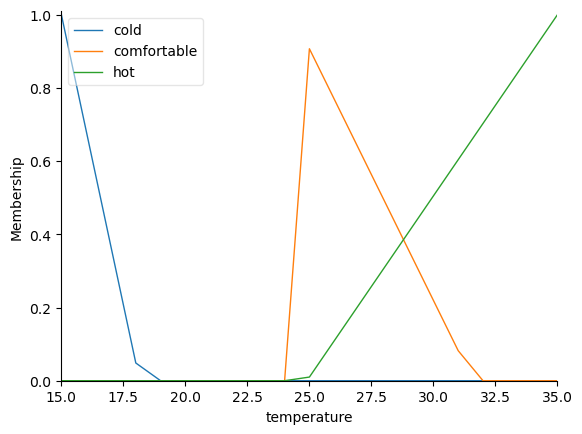

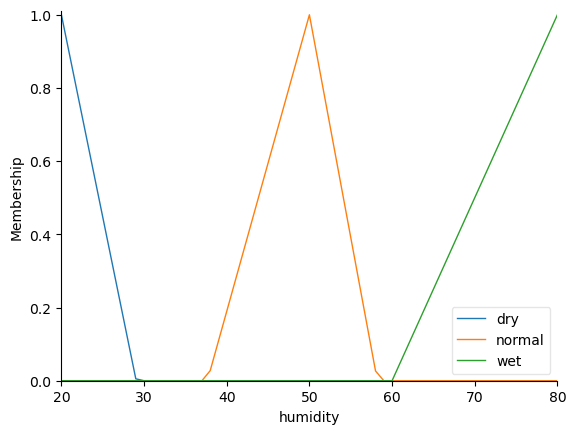

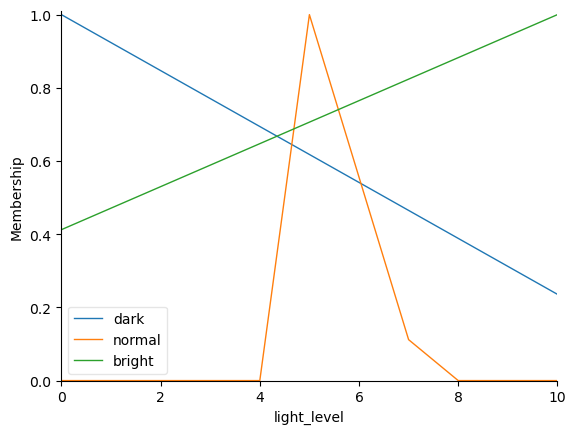

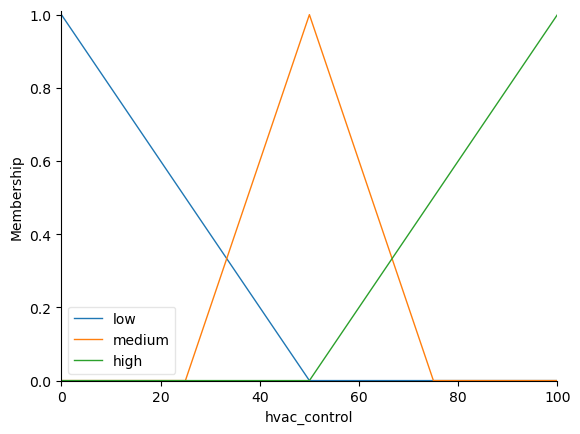

In [6]:
def main():
    # GA Setup
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    creator.create("Individual", np.ndarray, fitness=creator.FitnessMin)

    toolbox = base.Toolbox()
    toolbox.register("attr_float", random.uniform, 0, 1)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, 11)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("evaluate", evaluate_fitness)
    toolbox.register("mate", tools.cxBlend, alpha=0.5)
    toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.2)
    toolbox.register("select", tools.selTournament, tournsize=3)

    # Initialize Population
    population = toolbox.population(n=50)

    # Run GA
    algorithms.eaSimple(population, toolbox, cxpb=0.7, mutpb=0.2, ngen=20,
                        stats=None, halloffame=None, verbose=True)

    # Get Best Individual
    best_ind = tools.selBest(population, k=1)[0]
    print("Optimized Parameters:", best_ind)

    # Update and Visualize
    update_membership_functions(best_ind)
    temperature.view()
    humidity.view()
    light_level.view()
    hvac_control.view()
    plt.show()

if __name__ == "__main__":
    main()
